In [1]:
import os
import os.path as op
import sys

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

#from bluemath_tk.wrappers.swash.swash_wrapper import SwashModelWrapper
#from IPython.display import HTML

from scripts.wrappers import SwashModelWrapper_ondas

from scripts.bathymetry import linear_profile
from scripts.plots import plot_case_config

## 01.Define Case Variables

#### Necessary Paths

In [2]:
templates_dir = '/workspaces/ONDAS_Swash/templates'
output_dir = '/workspaces/ONDAS_Swash/cases'

#### Hydrodynamic Forcing

In [3]:
Hs = 2.5
Tp = 10.0
Hs_L0 =  round((2 * np.pi * (Hs)) / (9.81 * (Tp ** 2)),4)  # Should be between 0.005 and 0.05
WL = 1.0

In [4]:
Hs_L0

0.016

#### Create Bathymetry

In [5]:
h0 = -12  # offshore depth (m)
Ltotal = 1000  # beach heigh (m)
m = 10 / 300  # profile slope
Wfore = 400  # flume length before fore toe (m)

x_profile, depth_array = linear_profile(h0=h0, Ltotal=Ltotal, Wconst=Wfore, slope=m)

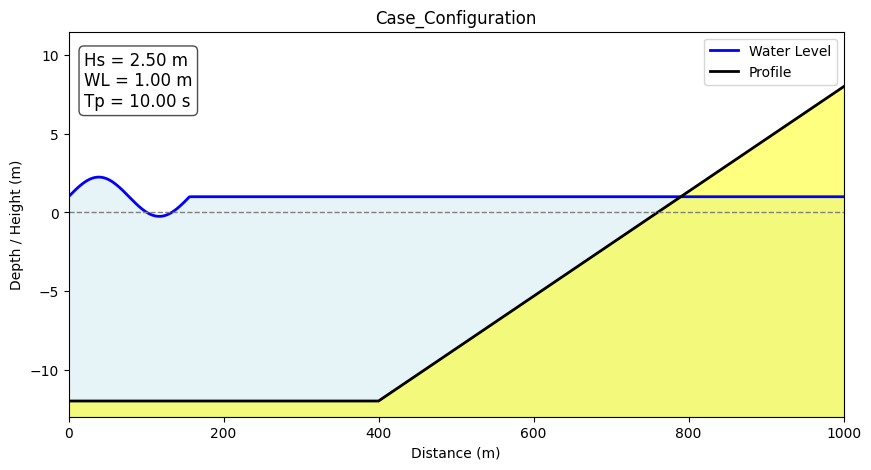

In [6]:
plot_case_config(x=x_profile, z=depth_array, wave_height=Hs, wave_period = Tp, WL=WL)

In [7]:
metamodel_parameters = pd.DataFrame({'Hs': Hs, 'Hs_L0': Hs_L0, 'WL': WL}, index=[0]).to_dict(orient='list')
fixed_parameters = {
    "dxinp": 1,  # bathymetry grid spacing  # Friction manning coefficient (m^-1/3 s)
    "comptime": 300,  # Simulation duration (s)
    "warmup": 300,  # Warmup duration (s)
    "n_nodes_per_wavelength": 60,  # number of nodes per wavelength
}

swash_model = SwashModelWrapper_ondas(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=-depth_array,
)

In [8]:
swash_model.build_cases()

In [10]:
swash_model.run_cases(launcher='serial')

In [22]:
vars_to_postprocess = ["Msetup", "Hrms", "Hfreqs"]
postprocessed = swash_model.postprocess_cases(output_vars=vars_to_postprocess).isel(case_num=0)

In [23]:
postprocessed

<xarray.Dataset> Size: 56kB
Dimensions:   (Xp: 1001)
Coordinates:
  * Xp        (Xp) int64 8kB 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
    Yp        int64 8B 0
    case_num  int64 8B 0
Data variables:
    Msetup    (Xp) float64 8kB 0.04505 0.04379 0.04186 ... 6.933 6.967 6.991
    Hrms      (Xp) float64 8kB 2.553 2.542 2.518 2.501 ... 0.0 0.0 0.0 2.512e-15
    Hs        (Xp) float64 8kB 3.609 3.595 3.562 ... 9.73e-15 6.486e-15 0.0
    Hss       (Xp) float64 8kB 3.605 3.591 3.558 ... 3.529e-18 2.353e-18 0.0
    ig        (Xp) float64 8kB 0.1717 0.1738 0.1729 ... 9.73e-15 6.486e-15 0.0
    Hvlf      (Xp) float64 8kB 0.0409 0.04132 0.04054 ... 6.072e-15 0.0

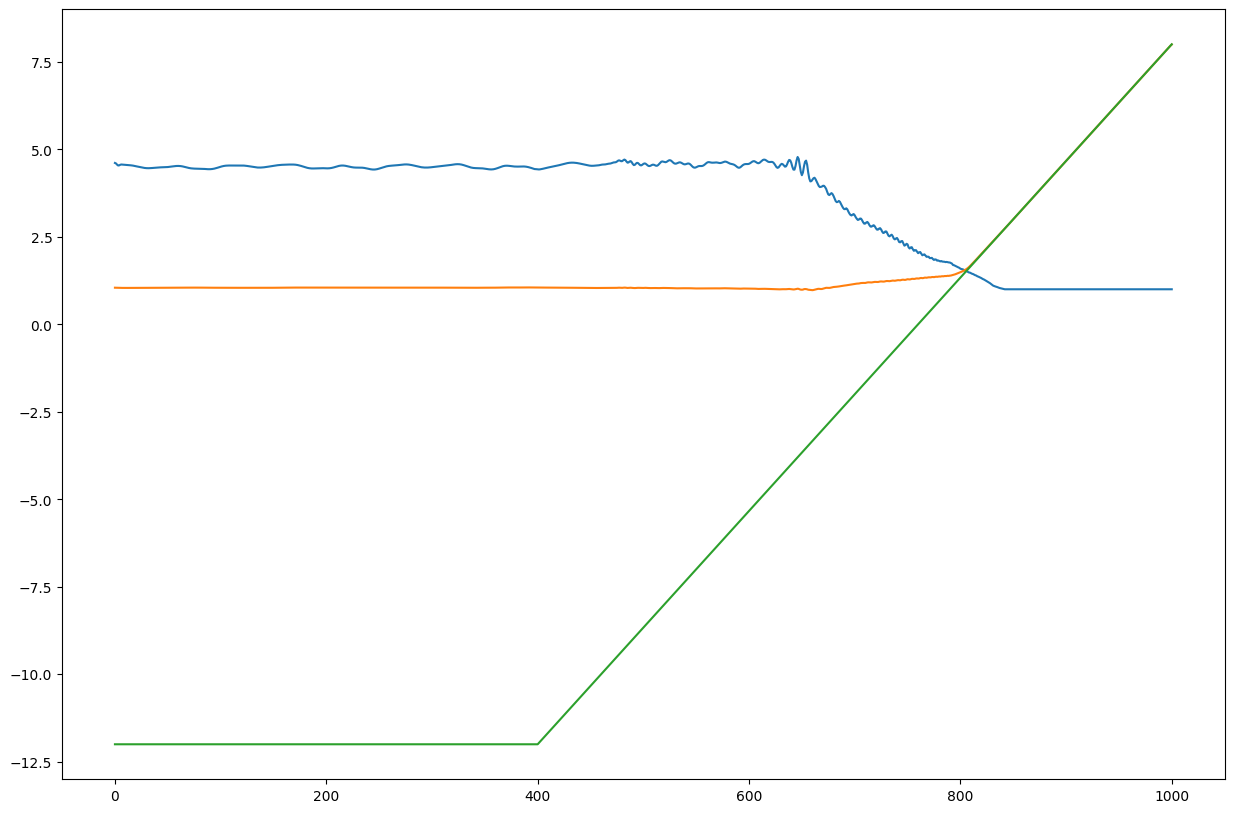

In [29]:
fig, axs = plt.subplots(1,1, figsize=(15,10))

axs.plot(postprocessed.Xp.values,postprocessed.Hs.values + 1)
axs.plot(postprocessed.Xp.values, postprocessed.Msetup.values + 1)
axs.plot(postprocessed.Xp.values, depth_array)
plt.show()